In [26]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
import numpy as np
import math
from random import randint

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

# 1. QPE

URL paper: https://arxiv.org/pdf/1805.10928.pdf

In [27]:
def crz(circ, tetha, a, b): 
    circ.rz(b, tetha/2)
    circ.cnot(a,b)
    circ.rz(b, -tetha/2)
    circ.cnot(a,b)

In [28]:
def controlled_U(circ,a,b,c,d,n,k):
    """this is corresponding to the C-U_j in equation (8) """
    crz(circ, c-a, n_ancilla-k, n_ancilla+n)
    circ.rz(n_ancilla-k, a)  
    crz(circ, b-a, n_ancilla-k, n_ancilla+n+1)
    circ.ccnot(n_ancilla-k, n_ancilla+n, n_ancilla+n+1)
    circ.rz(n_ancilla+n+1, d+c-b-a)
    circ.ccnot(n_ancilla-k, n_ancilla+n, n_ancilla+n+1)

In [29]:
def qft_dagger(circ, n):
    """n-qubit QFTdagger on q in circ."""
    for j in range(n):
        k = (n-1) - j
        for m in range(k):
            crz(circ, -math.pi/float(2**(k-m)), k, m)
        circ.h(k)


In [30]:
n_ancilla = 6
n_eigenvector = 8

In [31]:
def recover_task_result(task_load):
    # recover task
    sleep_times = 0
    while sleep_times < 100000:
        status = task_load.state()
        print('Status of (reconstructed) task:', status, '(',time.time(),')')
        print('\n')
        # wait for job to complete
        # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
        if status == 'COMPLETED':
            # get results
            return task_load.result()
        else:
            time.sleep(1)
            sleep_times = sleep_times + 1
    print("Quantum execution time exceded")
    return None


def QPE(eigenstate):
    
    #implementation limited to 8 qubits eigenstates
    if len(eigenstate)!=n_eigenvector:
        return None
    
    qpe = Circuit()

    for i in range(0, n_eigenvector):
        if eigenstate[i]=="1":
            qpe.x(n_ancilla+i) 

    for i in range(n_ancilla):
        qpe.h(i)

    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,1)
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,1)
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,1)
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,1)
    for i in range(2):
        controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,2)
        controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,2)
        controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,2)
        controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,2)
    for i in range(4):
        controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,3)
        controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,3)
        controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,3)
        controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,3)
    for i in range(8):
        controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,4)
        controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,4)
        controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,4)
        controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,4)
    for i in range(16):
        controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,5)
        controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,5)
        controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,5)
        controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,5)
    for i in range(32):
        controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,6)
        controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,6)
        controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,6)
        controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,6)

    qft_dagger(qpe,6)

    # for i in range(n_ancilla):
    #     qpe.measure(q[i],c[i])
    #print(qpe)

#     # set up device
#     device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-9")

#     # run circuit
    
#     s3_folder = ("amazon-braket-7c2f2fa45286", "api")  # Use the S3 bucket you created during onboarding

#     task = device.run(qpe, s3_folder, shots=1000, poll_timeout_seconds=5 * 24 * 60 * 60)
#     return recover_task_result(task).measurement_counts
    
        # set up device
    device = LocalSimulator()

    # run circuit
    result = device.run(qpe, shots=10000).result()
    # get measurement shots
    counts = result.measurement_counts

    
    
    
    # print counts
    print(counts)
    
    return counts



In [32]:
counts = QPE("11000110")

Counter({'11010111000110': 971, '00101011000110': 634, '00111111000110': 577, '00110111000110': 546, '00111011000110': 441, '10010111000110': 420, '11000111000110': 375, '11011111000110': 347, '01010111000110': 333, '01110111000110': 273, '00101111000110': 234, '10111111000110': 230, '01111111000110': 212, '11011011000110': 210, '11010011000110': 209, '00010111000110': 207, '10111011000110': 197, '00100011000110': 193, '11111011000110': 191, '10101011000110': 164, '11110111000110': 155, '01111011000110': 152, '01101011000110': 144, '00110011000110': 141, '00001011000110': 141, '10011111000110': 122, '01000111000110': 121, '10000111000110': 111, '11111111000110': 106, '11100111000110': 103, '01011111000110': 103, '10101111000110': 102, '11110011000110': 97, '11101111000110': 97, '00011111000110': 95, '10110111000110': 90, '10010011000110': 90, '11001011000110': 84, '01110011000110': 81, '01101111000110': 78, '01010011000110': 77, '10110011000110': 77, '01011011000110': 73, '100110110001

In [33]:
measure = list(counts.keys())[0]
eigenstate = measure[n_ancilla:]
phase = measure[:n_ancilla]
print ("Phase for eigenstate",eigenstate,":",phase)

Phase for eigenstate 11000110 : 111101


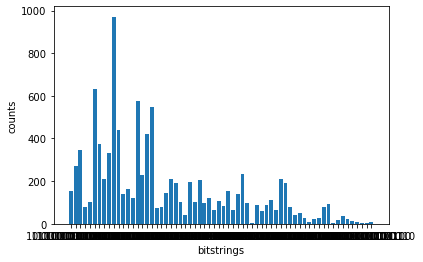

In [34]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.show()

In [35]:
#compute phase for all eigenstates

eigenstates = ["11000110","01101100","10001101","01110010","11100001","10110100"]
results = {}
for e in eigenstates:
    counts = QPE(e)
    measure = list(counts.keys())[0]
    eigenstate = measure[n_ancilla:]
    phase = measure[:n_ancilla]
    results[eigenstate] = phase

Counter({'11010111000110': 1047, '00101011000110': 660, '00111111000110': 628, '00110111000110': 479, '00111011000110': 455, '10010111000110': 419, '11000111000110': 355, '01010111000110': 343, '11011111000110': 337, '01111111000110': 239, '11011011000110': 239, '10111111000110': 223, '11010011000110': 222, '00101111000110': 217, '01110111000110': 216, '00010111000110': 209, '10111011000110': 189, '11110111000110': 174, '00110011000110': 169, '11111011000110': 168, '00100011000110': 168, '10101011000110': 160, '01111011000110': 156, '00001011000110': 151, '01101011000110': 144, '10011111000110': 134, '01000111000110': 131, '10000111000110': 124, '11111111000110': 99, '10101111000110': 98, '01011111000110': 92, '11101111000110': 92, '11100111000110': 90, '00011111000110': 87, '11110011000110': 83, '01010011000110': 83, '10010011000110': 82, '10110011000110': 82, '10110111000110': 76, '11001011000110': 75, '01110011000110': 74, '10100011000110': 74, '00001111000110': 71, '10011011000110'

In [36]:
#compute phase for all eigenstates

eigenstates = ["11000110", "10001101", "11100001"]
results = {}
for e in eigenstates:
    counts = QPE(e)
    measure = list(counts.keys())[0]
    eigenstate = measure[n_ancilla:]
    phase = measure[:n_ancilla]
    results[eigenstate] = phase

Counter({'11010111000110': 1033, '00101011000110': 632, '00111111000110': 557, '00110111000110': 545, '00111011000110': 441, '11000111000110': 418, '10010111000110': 385, '01010111000110': 360, '11011111000110': 318, '01110111000110': 276, '11011011000110': 231, '11010011000110': 216, '10111111000110': 215, '10111011000110': 214, '00101111000110': 206, '01111111000110': 204, '11110111000110': 183, '01111011000110': 180, '11111011000110': 169, '00100011000110': 168, '10101011000110': 155, '00110011000110': 154, '00010111000110': 151, '00001011000110': 150, '01101011000110': 135, '10011111000110': 134, '01000111000110': 134, '10000111000110': 123, '11100111000110': 110, '10101111000110': 109, '00011111000110': 103, '11110011000110': 101, '10110111000110': 98, '01011111000110': 88, '10010011000110': 88, '11101111000110': 85, '00001111000110': 83, '10110011000110': 83, '01010011000110': 83, '11001011000110': 79, '11111111000110': 77, '01110011000110': 75, '10100011000110': 66, '01011011000

In [37]:
for e in results.keys():
    print ("Phase for eigenstate",e,":",results[e])

Phase for eigenstate 11000110 : 110001
Phase for eigenstate 10001101 : 111001
Phase for eigenstate 11100001 : 000010
